# Initialisation

In [1]:
import OsloModel.analysis as analysis
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tqdm import trange
from collections import OrderedDict
from OsloModel.agent import Site
from OsloModel.model import Pile
from scipy.optimize import curve_fit

In [2]:
power_law = lambda x, a, p: a * x ** p
linear_regression = lambda x, c, m: m * x + c

Define the power law and regression functions, this will be repeatedly used for fitting of data.

# Task 1

In [3]:
from OsloModel.model import Pile

btw_pile_16 = Pile(length=16, probabilities=[1,0], threshold_zs=[1,2], name="BTW Model")
oslo_pile_16 = Pile(length=16, probabilities=[0.5,0.5], threshold_zs=[1, 2], name="Oslo Model")

In [4]:

btw_pile_16.get_threshold_slopes()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


As expected in the original Oslo Model the threshold slopes are all 1.

In [5]:
oslo_pile_16.get_threshold_slopes()

[1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1]


In the oslo_pile_xs there is a 50/50 probability of being either 2 or 1. These are updated every avalanche.

In [6]:
for _ in range(500):
    btw_pile_16.drop_grain()
    
btw_pile_16.get_heights()

[16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


The heights of the BTW model will each differ by one and move from left to right.

In [7]:

# i = 0
btw_pile_16.drop_grain()
btw_pile_16.ava_size

16

In [8]:

# i = 6
btw_pile_16.drop_grain(site_index=6)
btw_pile_16.ava_size

10

In [9]:

for _ in range(500):
    oslo_pile_16.drop_grain()
    
oslo_pile_16.get_heights()

[26, 25, 24, 23, 21, 19, 17, 15, 13, 11, 10, 8, 6, 5, 3, 1]


In [10]:

pile_heights = []

for i in range(10000):
    oslo_pile_16.drop_grain()
    pile_heights.append(oslo_pile_16.get_pile_height())
    
np.average(pile_heights)

26.4972

The total height of the pile is found analytically to approach 26.5 for a system of size L=16.

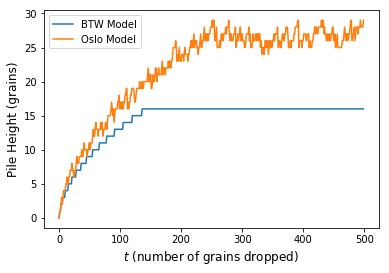

In [11]:
# reinitialise the piles
btw_pile_16.reset()
oslo_pile_16.reset()

for i in (btw_pile_16, oslo_pile_16):
    pile_heights = []
    
    # drop 500 grains
    for t in range(500):
        pile_heights.append(i.get_pile_height())
        i.drop_grain()
    plt.plot(pile_heights, label=i.name, color=)
    
plt.xlabel("$t$ (number of grains dropped)", fontsize=14)
plt.ylabel("Pile Height (grains)", fontsize=14)
plt.legend(loc=0)
plt.show()

Whilst the two systems are both of size L=16, the Oslo model has many more grains in it as height of individual sites are on average greater by a factor of 50%. The fluctuation around the average value of 26.5 is what is expected of the Oslo Model.

The code drops 1,000,000 grains after the pile has reached a steady state. Therefore the total number of grains dropped will increase with system size. All the data is stored as a nested dictionary:

{{8: {'heights': [1, 2, 3...], 'avalanche size': [0, 0, 0...]},

{16: {'heights': [1, 2, 3...], 'avalanche size': [0, 0, 0...]},

{32: {'heights': [1, 2, 3...], 'avalanche size': [0, 0, 0...]},

{64: {'heights': [1, 2, 3...], 'avalanche size': [0, 0, 0...]},

{128: {'heights': [1, 2, 3...], 'avalanche size': [0, 0, 0...]},

{256: {'heights': [1, 2, 3...], 'avalanche size': [0, 0, 0...]},


The steady state time period must be the same as below. The data is then pickled and loaded for later use.

In [12]:
data_dict = pickle.load(open('C:/Users/18072/PycharmProjects/Complexity_Networks/height_and_avalanche_data', 'rb'))
# defined by the number of grains dropped
steady_state_time_period = 1000000

## Task 2a
### Measuring the Height of Different System Sizes

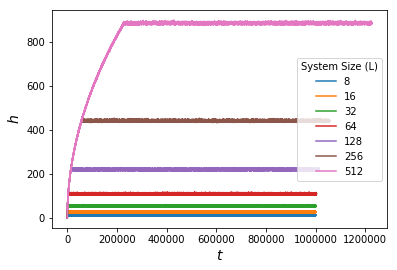

In [13]:
for length, pile_dict in data_dict.items():
    plt.plot(pile_dict['heights'], label=length)

plt.xlabel("$t$", fontsize=14)
plt.ylabel("$h$", fontsize=14)
plt.legend(loc=0, title="System Size (L)", framealpha=0.8, prop={'size':10})
plt.show()

As we can see, the height of the piles initially follows a curve. This is when the pile is still in transient configurations. At certain times, the heights flatten, denoting the corresponding piles reaching recurrent configurations.

To get a rough estimation of the cross-over times $(t_c(L))$, and pile height in the steady state $(h_c(L))$, we first find the moving average of the data and display them on a log-log plot:

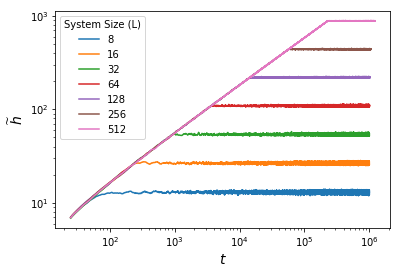

In [14]:

temporal_window = 50
start_time = int(temporal_window / 2)

for length, pile_dict in data_dict.items():
    smooth_data = analysis.moving_average(pile_dict['heights'], temporal_window)
    times = np.arange(start_time, len(smooth_data) + start_time)
    plt.loglog(times, smooth_data, label=length)

plt.xlabel("$t$", fontsize=14)
plt.ylabel("$\widetilde h$", fontsize=14)
plt.legend(loc=2, title="System Size (L)", framealpha=0.8, prop={'size':10})
plt.show()

Performing the smoothing of the data for different system sizes. By varying the size of the temporal window over which the smoothing occurs, different levels of smoothness can be achieved. It was found that temporal_window = 20 was optimal

We can then estimate the values by finding the intercepts of the lines.

To calculate the cut_off time additional data was loaded in of the format

{4: [mean, sd], 8: [mean, sd], ... 512: [mean, sd]}

Where the mean and standard deviation were calculated from running 10 simulations. This is considered to be appropriate as the model is a random

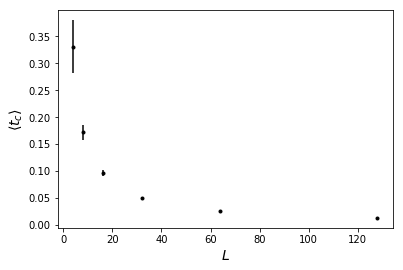

In [84]:
cut_off_time_dict = pickle.load(open('C:/Users/18072/PycharmProjects/Complexity_Networks/cut_off_time_data', 'rb'))
mean, sd = [], []
for length in [4, 8, 16, 32, 64, 128]:
    mean.append(cut_off_time_dict[length][0] / length**2)
    sd.append(cut_off_time_dict[length][1] / length**2)
plt.errorbar([4, 8, 16, 32, 64, 128], mean, yerr=sd, fmt='.', color='black')
plt.ylabel(r"$\langle t_c \rangle$", fontsize=14)
plt.xlabel("$L$", fontsize=14)
plt.show()

## Task 2b
### Data Collapse and Smoothing

Plot $\widetilde h/L$ against $t/L^2$:

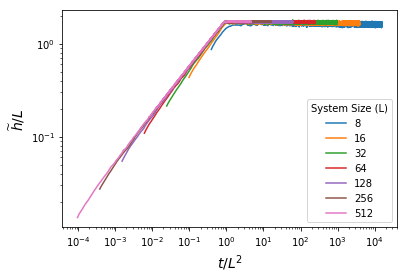

In [16]:
for length, pile_dict in data_dict.items():
    smooth_collapsed_heights = analysis.moving_average(pile_dict['heights'], temporal_window) / length
    collapsed_time = np.arange(start_time, len(smooth_collapsed_heights) + start_time) / length**2
    plt.loglog(collapsed_time, smooth_collapsed_heights, label=length)
    
plt.xlabel("$t/L^2$", fontsize=14)
plt.ylabel("$\widetilde h/L$", fontsize=14)
plt.legend(loc=0, title="System Size (L)", framealpha=0.8, prop={'size':10})
plt.show()

This plot shows a sharp transition. In reality the sharpness of this transition from transient to recurrent is only present for large values of L. Which can be proved by zooming in.

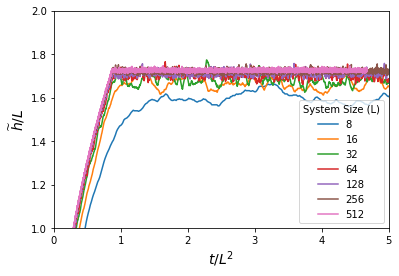

In [17]:
for length, pile_dict in data_dict.items():
    smooth_collapsed_heights = analysis.moving_average(pile_dict['heights'], temporal_window) / length
    collapsed_time = np.arange(start_time, len(smooth_collapsed_heights) + start_time) / length**2
    plt.plot(collapsed_time, smooth_collapsed_heights, label=length)
    
plt.axis((0.0, 5.0, 1.0, 2.0))
plt.xlabel("$t/L^2$", fontsize=14)
plt.ylabel("$\widetilde h/L$", fontsize=14)
plt.legend(loc=4, title="System Size (L)", framealpha=0.8, prop={'size':10})
plt.show()

$$\widetilde h\left(t; L\right) = L^{1}\mathcal{F}\left(\frac{t}{L^2}\right)$$
As the system size tends to $\infty$, $\mathcal{F}(x)$ is discontinous at $x=1$. For $x < 1$, $\mathcal{F}(x)$ follows a power law. For $x \geqslant 1$, $\mathcal{F}(x)$ is constant.

This is because the system experiences a phase trasition from the trasient state to the recurrent state, indicated by the non-zero outflux.

Taking the data for $L = 512$, we can fit a power law to find how $\widetilde h\left(t; L\right)$ relates to $t$ in the transient state:

In [18]:
starting_t = 1000

height_data = data_dict[512]['heights'][starting_t:-steady_state_time_period]
t = np.arange(starting_t, len(height_data) + starting_t)

(a, p), cov = curve_fit(power_law, t, height_data)
a, p, analysis.calculate_std_from_cov_matrix(cov)

(1.7702056565687259,
 0.5035674163791413,
 array([2.53017417e-04, 1.20708602e-05]))

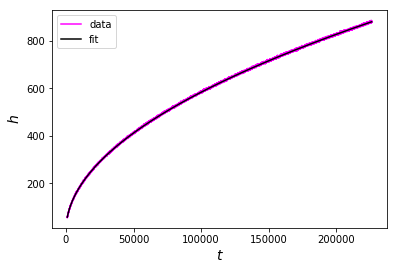

In [19]:
color_dict = {'fit': 'red', 'data': 'black'}

plt.plot(t, height_data, label='data', color=color_dict['data'])
plt.plot(t, power_law(t, a, p), label='fit', color=color_dict['fit'])

plt.xlabel("$t$", fontsize=14)
plt.ylabel("$h$", fontsize=14)
plt.legend(loc=0)
plt.show()

Hence the curve that fits the data is given by $h = (1.7702 \pm 0.0003) t^{0.50357 \pm 0.00001}$ for L=512. The power law has excellent agreement with the data.

## Task 2c
### Average Height vs. System Size
We can take the last 1,000,000 data points to calculate the average height at the steady state:

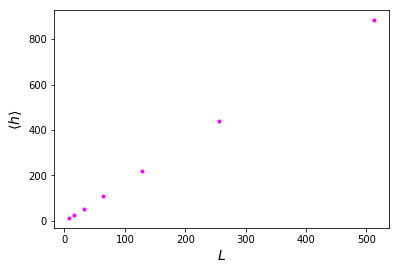

In [20]:
# Construct a dictionary to store the data points
system_lengths = np.array(list(data_dict.keys()))
average_heights = [np.average(pile_dict['heights'][-steady_state_time_period:]) for pile_dict in data_dict.values()]

plt.plot(system_lengths, average_heights, '.', color=color_dict['data'])

plt.xlabel("$L$", fontsize=14)
plt.ylabel(r"$\langle h \rangle$", fontsize=14)
plt.show()

We see the line is not longer straight when system length is small. Boundary effects become siginificant. This assumption needs to be quantified. Invalid otherwise.

We first try fit with first order correction:

In [21]:

get_average_pile_height_from_L = lambda L, a0, a1, w1: a0 * L * (1 - a1 * L ** (-w1))

(a0, a1, w1), cov = curve_fit(get_average_pile_height_from_L, system_lengths, average_heights, absolute_sigma=True)

a0, a1, w1, analysis.calculate_std_from_cov_matrix(cov)

(1.7341713154661471,
 0.23849160098376307,
 0.612709122762152,
 array([0.01385287, 0.35910523, 0.45789451]))

$$\langle h \rangle = a_0L(1 - a_1L^{-\omega_1})$$

where $a_0 = \langle z \rangle = 1.734 \pm 0.014$, $a_1 = 0.238 \pm 0.359,$ and $\omega_1 = 0.613 \pm 0.458$

The uncertainties are high, because it is a 3 parameter optimisation.

We can also obtain the parameters from taking the log of both side.

$$log(a_0L-\langle h \rangle) = (1 - \omega_1) log(a_0a_1L)$$
Using the parameters, let's see how well the fit is:

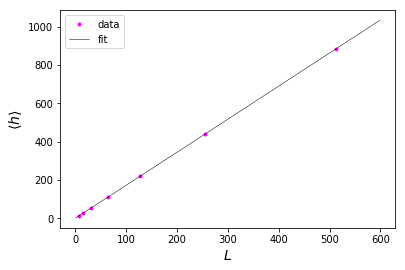

In [22]:
Ls = np.arange(1, 600)

plt.plot(system_lengths, average_heights, '.', color='magenta', label='data')
plt.plot(Ls, get_average_pile_height_from_L(Ls, a0, a1, w1), color='black', label='fit', linewidth=0.5)

plt.xlabel("$L$", fontsize=14)
plt.ylabel(r"$\langle h \rangle$", fontsize=14)
plt.legend(loc=0)
plt.show()

We can clearly see the sign of corrections to scaling for small $L$:

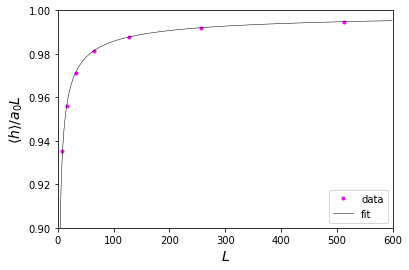

In [23]:
plt.plot(system_lengths, average_heights / (a0 * system_lengths), '.', color='magenta', label='data')
plt.plot(Ls, get_average_pile_height_from_L(Ls, a0, a1, w1) / (a0 * Ls), color='black', label='fit', linewidth=0.5)

plt.xlabel("$L$", fontsize=14)
plt.ylabel(r"$\langle h \rangle /a_0L$", fontsize=14)
plt.axis((0, 600, 0.9, 1.0))
plt.legend(loc=4)
plt.show()

This is plotting $\langle h \rangle = 1 - a_{1}L^{- \omega_{1}}$ against L. The value of $\langle h \rangle$ tends towards 1 as L tends to $\infty$

### Standard deviation vs System Size

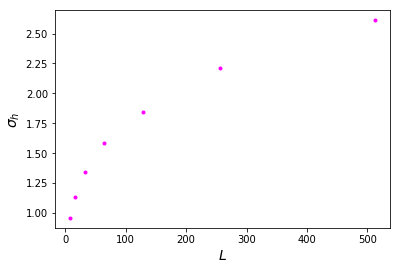

In [24]:
standard_deviations = [np.std(pile_dict['heights'][-steady_state_time_period:]) for pile_dict in data_dict.values()]
plt.plot(system_lengths, standard_deviations, '.', color='magenta', label='data')

plt.xlabel("$L$", fontsize=14)
plt.ylabel(r"$\sigma_h$", fontsize=14)
plt.show()

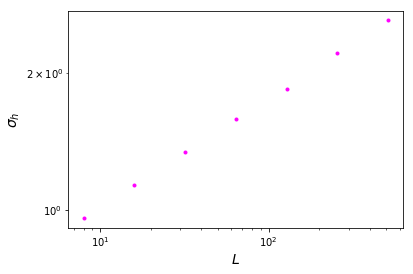

In [25]:
standard_deviations = [np.std(pile_dict['heights'][-steady_state_time_period:]) for pile_dict in data_dict.values()]
plt.loglog(system_lengths, standard_deviations, '.', color='magenta', label='data')

plt.xlabel("$L$", fontsize=14)
plt.ylabel(r"$\sigma_h$", fontsize=14)
plt.show()

Looks like a power law relation, so:

In [26]:

(a, w), cov = curve_fit(power_law, system_lengths, standard_deviations)

a, w, analysis.calculate_std_from_cov_matrix(cov)

(0.5806534351239225, 0.24062723662009047, array([0.0059917 , 0.00200217]))

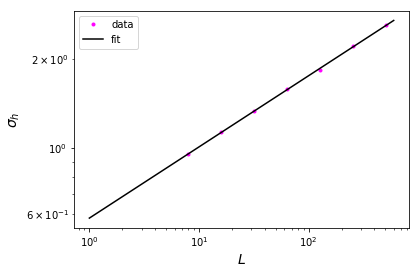

In [27]:

plt.loglog(system_lengths, standard_deviations, '.', color='magenta', label='data')
plt.loglog(Ls, power_law(Ls, a, w), color='black', label='fit')

plt.legend(loc=0)
plt.xlabel("$L$", fontsize=14)
plt.ylabel(r"$\sigma_h$", fontsize=14)
plt.show()

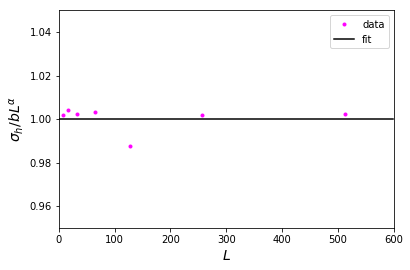

In [28]:
plt.plot(system_lengths, standard_deviations / (a * system_lengths ** w), '.', color='magenta', label='data')
plt.plot(Ls, power_law(Ls, a, w) / (a * Ls ** w), color='black', label='fit')

plt.legend(loc=0)
plt.xlabel("$L$", fontsize=14)
plt.ylabel(r"$\sigma_h/bL^{\alpha}$", fontsize=14)
plt.axis((0, 600, 0.95, 1.05))
plt.show()

So there appears to be no corrections to scaling needed

## Task 2d

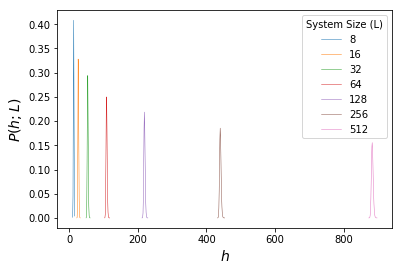

In [29]:
for length, pile_dict in data_dict.items():
    height_prob_dict = analysis.calculate_height_probability(pile_dict['heights'][-steady_state_time_period:])
    plt.plot(list(height_prob_dict.keys()), list(height_prob_dict.values()), '-', label=length, linewidth=0.5)
    
plt.legend(loc=0, title="System Size (L)",  framealpha=0.8, prop={'size':10})
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$P(h; L)$", fontsize=14)
plt.show()

The approximately Gaussian distributions of height are shown in the plot above. As we have already seen the $\langle h \rangle$ scales with $a_{0} L$. A data collapse is then performed on the data to generate the plot shown below.

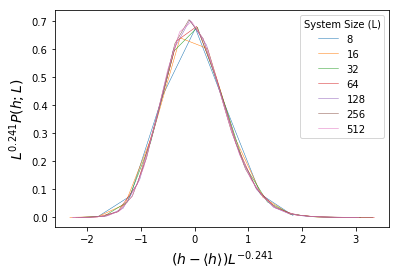

In [30]:
for length, pile_dict in data_dict.items():
    height_prob_dict = analysis.calculate_height_probability(pile_dict['heights'][-steady_state_time_period:])
    collapsed_h = (np.array(list(height_prob_dict.keys()))-average_heights[list(data_dict.keys()).index(length)]) / length ** w 
    collapsed_p = np.array(list(height_prob_dict.values())) * length ** w
    plt.plot(collapsed_h, collapsed_p, label=length, linewidth=0.5)
    
plt.legend(loc=0, title="System Size (L)",  framealpha=0.8, prop={'size':10})
plt.xlabel(r"$(h - \langle h \rangle) L^{-0.241}$", fontsize=14)
plt.ylabel("$L^{0.241}P(h; L)$", fontsize=14)
plt.show()

Plot the data on a logarithmic y axis to...

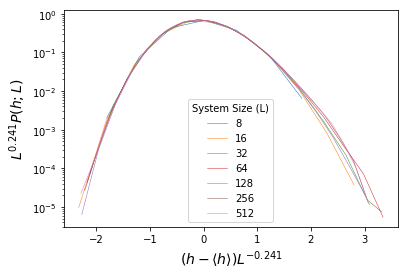

In [31]:
for length, pile_dict in data_dict.items():
    height_prob_dict = analysis.calculate_height_probability(pile_dict['heights'][-steady_state_time_period:])
    collapsed_h = (np.array(list(height_prob_dict.keys()))-average_heights[list(data_dict.keys()).index(length)]) / length ** w 
    collapsed_p = np.array(list(height_prob_dict.values())) * length ** w
    plt.semilogy(collapsed_h, collapsed_p, label=length, linewidth=0.5)
    
plt.legend(loc=0, title="System Size (L)",  framealpha=0.8, prop={'size':10})
plt.xlabel(r"$(h - \langle h \rangle) L^{-0.241}$", fontsize=14)
plt.ylabel("$L^{0.241}P(h; L)$", fontsize=14)
plt.show()

## The Avalanche-Size Probability

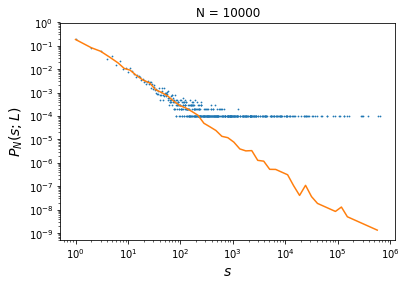

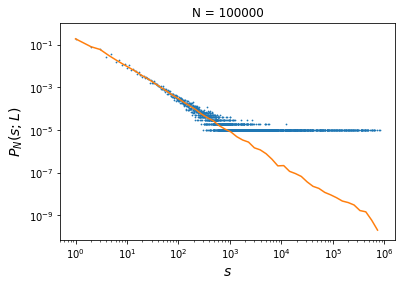

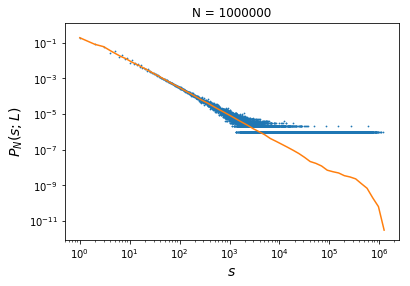

In [32]:
ava_size_512 = data_dict[512]['avalanche size']

no_of_samples = (10000, 100000, 1000000)

for i in no_of_samples:
    plt.figure()
    ava_size_prob_dict = analysis.calculate_avalanche_probability(ava_size_512[-i:])
    plt.loglog(list(ava_size_prob_dict.keys()), list(ava_size_prob_dict.values()), '.', ms=1.5)
    centres, probs = analysis.make_log_bins(ava_size_512[-i:], bin_scaling=1.3)
    plt.loglog(centres, probs, '-')
    plt.title("N = {}".format(i))
    plt.xlabel("$s$", fontsize=14)
    plt.ylabel("$P_N(s;L)$", fontsize=14)
    
plt.show()

$P_{N}(s;L) = \frac{\text{No. of avalanches in a system of size s in a system of size L}}{\text{total no. of avalanches N}}$



### Task 3b

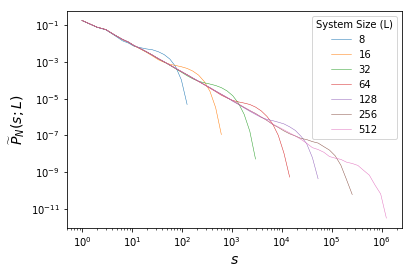

In [33]:
no_of_samples = 1000000

for length, pile_dict in data_dict.items():
    centres, probabilities = analysis.make_log_bins(pile_dict['avalanche size'][-no_of_samples:], bin_scaling=1.3)
    plt.loglog(centres, probabilities, '-', label=length, linewidth=0.5)

plt.legend(loc=0, title='System Size (L)', prop={'size':10})
plt.xlabel("$s$", fontsize=14)
plt.ylabel(r"$\widetilde P_N(s;L)$", fontsize=14)
plt.show()

Larger avalanches are less likely as can be expected. The size of avalanches follows a power-law decay such that very small avalanches form the majority of those present.

There is an unexpectedly high probability for large avalanches. The rest of the behaviour follows a power-law decay.

The bin_scaling has been set to $a=1.3$ as a good compromise between a smoooth curve and losing the resolution of the data.

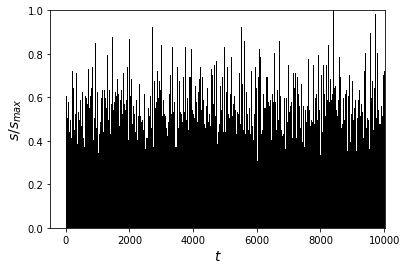

In [34]:
no_of_samples = 10000

ava_size_8 = data_dict[8]['avalanche size']
ava_size_8_cropped = ava_size_8[-no_of_samples:]

max_ava_size = max(ava_size_8[-no_of_samples:])
# normalised_ava_size_512 = [ava / 512 for ava in ava_size_512[-no_of_samples:]]
for num in range(no_of_samples):
    plt.axvline(x=num, ymin=0, ymax=ava_size_8_cropped[num]/max_ava_size, linewidth=1, color='black')
# plt.plot(ava_size_512, '.', ms=1.5)

# plt.legend(loc=0, title='System Size (L)', prop={'size':10})
plt.xlabel("$t$", fontsize=14)
plt.ylabel(r"$s/s_{max}$", fontsize=14)
plt.show()

### Task 3b

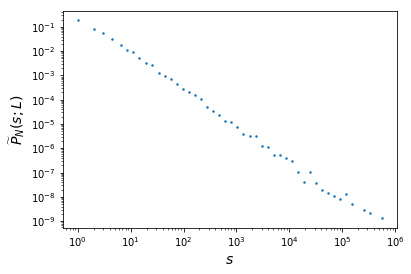

In [35]:
centres, probabilities = analysis.make_log_bins(data_dict[512]['avalanche size'][-no_of_samples:], bin_scaling=1.3)
plt.loglog(centres, probabilities, '.', ms=3.0)
plt.xlabel("$s$", fontsize=14)
plt.ylabel(r"$\widetilde P_N(s;L)$", fontsize=14)
plt.show()

The first 22 data points and the last 10 should be ignored and then the curve can be fit very well to a power law

In [36]:

power_law = lambda s, a, tau_s: a * s ** tau_s

(a, tau_s), cov = curve_fit(power_law, centres[22:-10], probabilities[22:-10])

a, tau_s, analysis.calculate_std_from_cov_matrix(cov)

(0.5173310569408255, -1.6008888795941691, array([0.36406656, 0.10206844]))

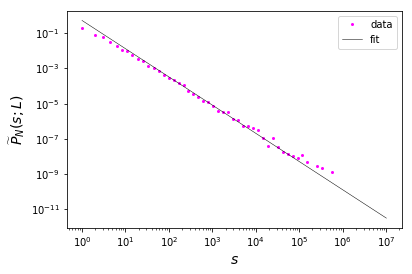

In [37]:
plt.loglog(centres, probabilities, '.', color='magenta', ms=4.0, label='data')

ava_sizes = np.logspace(0, 7, 100)
plt.loglog(ava_sizes, power_law(ava_sizes, a, tau_s), color='black', linewidth=0.5, label='fit')

plt.legend(loc=0)
plt.xlabel("$s$", fontsize=14)
plt.ylabel("$\widetilde P_N(s;L)$", fontsize=14)
plt.show()

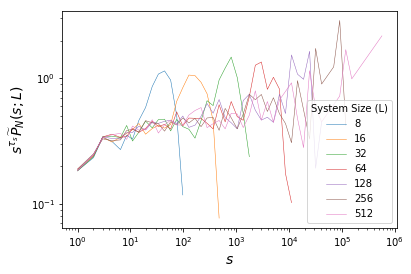

In [38]:

for length, pile_dict in data_dict.items():
    centres, probabilities = analysis.make_log_bins(pile_dict['avalanche size'][-no_of_samples:], bin_scaling=1.3)
    s_tau_probabilities = centres ** -tau_s * probabilities
    plt.loglog(centres, s_tau_probabilities, '-', label=length, linewidth=0.5)

plt.legend(loc=0, title='System Size (L)', prop={'size':10})
plt.xlabel("$s$", fontsize=14)
plt.ylabel(r"$s^{\tau_s} \widetilde P_N(s;L)$", fontsize=14)
plt.show()

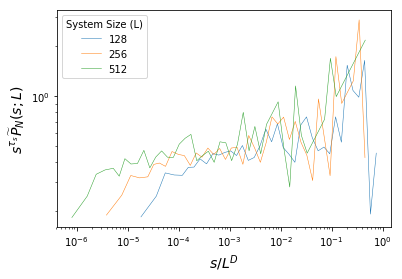

In [39]:
D = 2.25

for length, pile_dict in data_dict.items():
    if length >= 128:
        centres, probabilities = analysis.make_log_bins(pile_dict['avalanche size'][-no_of_samples:], bin_scaling=1.3)
        centre_L_minus_Ds = centres * length ** -D
        s_tau_probabilities = centres ** -tau_s * probabilities
        plt.loglog(centre_L_minus_Ds, s_tau_probabilities, '-', label=length, linewidth=0.5)
        
plt.legend(loc=0, title='System Size (L)')
plt.xlabel(r"$s/L^D$", fontsize=14)
plt.ylabel(r"$s^{\tau_s} \widetilde P_N(s;L)$", fontsize=14)
plt.show()

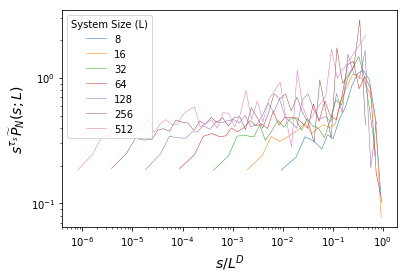

In [40]:

D = 2.25

for length, pile_dict in data_dict.items():
    centres, probabilities = analysis.make_log_bins(pile_dict['avalanche size'][-no_of_samples:], bin_scaling=1.3)
    centre_L_minus_Ds = centres * length ** -D
    s_tau_probabilities = centres ** -tau_s * probabilities
    plt.loglog(centre_L_minus_Ds, s_tau_probabilities, '-', label=length, linewidth=0.5)
        
plt.legend(loc=0, title='System Size (L)', prop={'size':10})
plt.xlabel(r"$s/L^D$", fontsize=14)
plt.ylabel(r"$s^{\tau_s} \widetilde P_N(s;L)$", fontsize=14)
plt.show()

And a complete data collapse has been performed in both axis. The equation $\widetilde P_N(s;L) \propto s^{− \tau s}\mathcal{G} (s/L^D)$ for $L \gg 1$, $s \gg 1$,

### Task 3c

In [41]:
ks = (1, 2, 3, 4, 5)
kth_moment_list = []

for k in ks:
    current_kth_moments = []
    for length, pile_dict in data_dict.items():
        kth_moment = np.average(np.array(pile_dict['avalanche size'][-steady_state_time_period:], dtype='float64') ** k)
        current_kth_moments.append([length, kth_moment])
    kth_moment_list.append(current_kth_moments)
    
kth_moment_array = np.array(kth_moment_list)

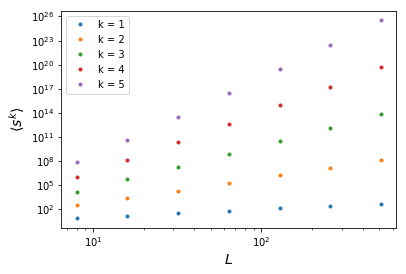

In [42]:

for i, k in enumerate(ks):
    plt.loglog(kth_moment_array[i, :, 0], kth_moment_array[i, :, 1], '.', label='k = {}'.format(k))

plt.legend(loc=0)
plt.xlabel('$L$', fontsize=14)
plt.ylabel(r'$\langle s^k \rangle$', fontsize=14)
plt.show()

[0.00024137992940721932, 0.026529163661265513, 0.05468590708072383, 0.07717903595139172, 0.09053639827817725]
[0.9993869604844261, 3.2552244187566863, 5.536930634752071, 7.829831028910025, 10.130461752936327]


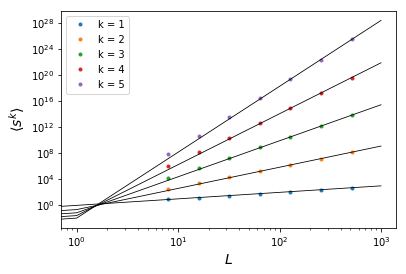

In [43]:
Ls = np.arange(0, 1000)
k_slopes = []
k_slope_errs = []

for i, k in enumerate(ks):
    plt.loglog(kth_moment_array[i, :, 0], kth_moment_array[i, :, 1], '.', label='k = {}'.format(k))
    
    (log_a, exp), cov = curve_fit(linear_regression, np.log(kth_moment_array[i, -3:, 0]), np.log(kth_moment_array[i, -3:, 1]))
    plt.loglog(Ls, power_law(Ls, np.exp(log_a), exp), color='black', linewidth=0.8)
    k_slopes.append(exp)
    k_slope_errs.append(analysis.calculate_std_from_cov_matrix(cov)[1])
    
print(k_slope_errs)
print(k_slopes)
plt.legend(loc=0)
plt.xlabel('$L$', fontsize=14)
plt.ylabel(r'$\langle s^k \rangle$', fontsize=14)
plt.show()

-1.2727773068139079 2.2721632217713728 [0.00588701 0.00588489]
1.5601610371202357


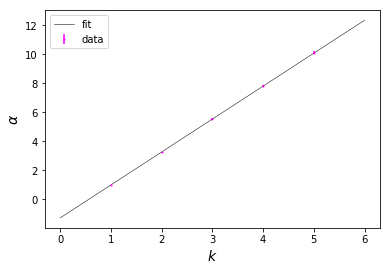

In [44]:
(c, D), cov = curve_fit(linear_regression, ks, k_slopes, sigma=k_slope_errs)
print(c, D, analysis.calculate_std_from_cov_matrix(cov))

tau_s = 1 - c / D
print(tau_s)

plt.errorbar(ks, k_slopes, yerr=k_slope_errs, color='magenta', fmt='.', label='data', ms=2.0)

ks_ = np.arange(7)
plt.plot(ks_, linear_regression(ks_, c, D), color='black', label='fit', linewidth=0.5)

plt.legend(loc=0)
plt.xlabel('$k$', fontsize=14)
plt.ylabel(r'$\alpha$', fontsize=14)
plt.show()